In [282]:
import osmnx as ox
import networkx as nx
from collections import deque
import random

In [2]:
ox.config(use_cache=True, log_console=True)

In [3]:
graph = ox.graph_from_bbox(48.1510, 48.1249, 11.5430, 11.6104, network_type='walk', simplify=True, retain_all=False)

In [4]:
graph_projected = ox.project_graph(graph)

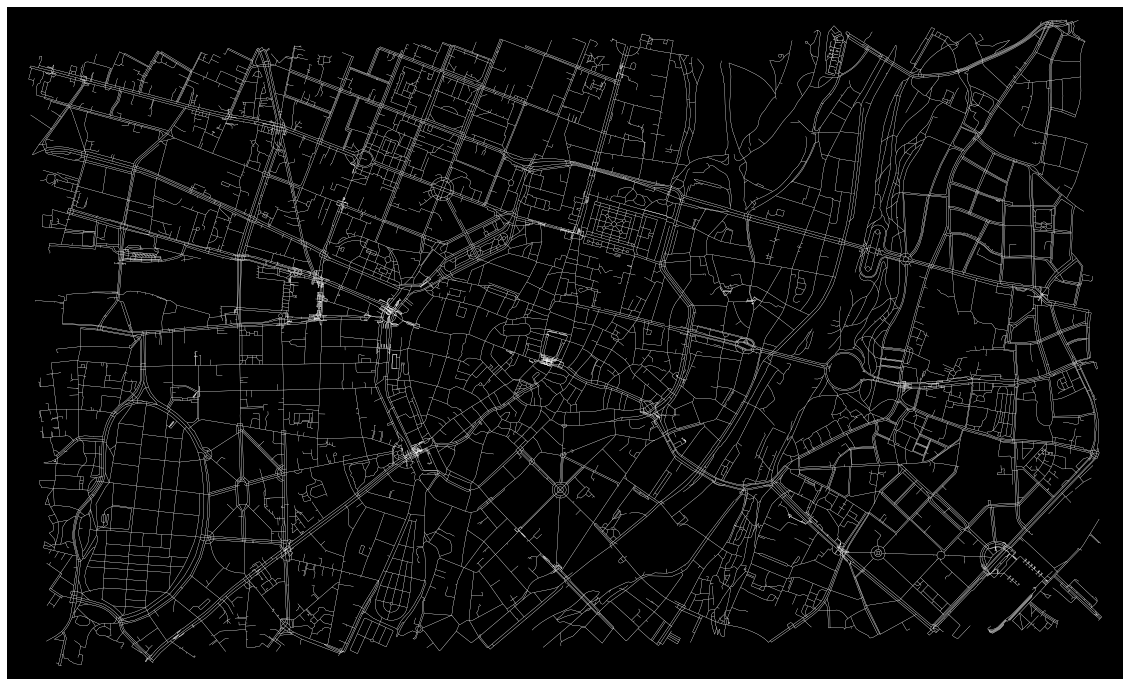

In [5]:
fig, ax = ox.plot_graph(graph_projected, node_size=0, edge_color='w', edge_linewidth=0.2, bgcolor='k', figsize=(20, 20), dpi=10000)

In [6]:
basic_stats = ox.basic_stats(graph_projected)

In [7]:
basic_stats

{'n': 11504,
 'm': 32776,
 'k_avg': 5.698191933240612,
 'edge_length_total': 1090231.3699999838,
 'edge_length_avg': 33.26310013424408,
 'streets_per_node_avg': 2.8786509040333796,
 'streets_per_node_counts': {0: 0,
  1: 2257,
  2: 2,
  3: 6291,
  4: 2815,
  5: 121,
  6: 12,
  7: 3,
  8: 3},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.19619262865090403,
  2: 0.00017385257301808066,
  3: 0.5468532684283728,
  4: 0.24469749652294853,
  5: 0.01051808066759388,
  6: 0.001043115438108484,
  7: 0.000260778859527121,
  8: 0.000260778859527121},
 'intersection_count': 9247,
 'street_length_total': 545115.6849999999,
 'street_segment_count': 16388,
 'street_length_avg': 33.26310013424457,
 'circuity_avg': 1.0387513110418476,
 'self_loop_proportion': 0.002074688796680498}

In [8]:
# Gets the all the nodes and edges from a graph
nodes, edges = ox.graph_to_gdfs(graph_projected, nodes=True, edges=True)

In [345]:
#Gets a random start and random target to test each time
nodes_list = []
for row in nodes.itertuples(index=True):
    nodes_list.append(row[0]) 
    
# Start
start = random.choice(nodes_list)

# Goal
target = random.choice(nodes_list)

In [392]:
# Testing out Algorithm

# Infinity should be at least as big as the edges cumulative distance 
# Thus, greater than "street_length_total: 545115"
infinity = 99999999

#Records the shortest distance to give each node, it will be updated as we go
shortest_distance = {} 

# All nodes should be set to infinity. Start node to 0.
for row in nodes.itertuples(index=True):
    shortest_distance[row[0]] = infinity 
shortest_distance[start] = 0

In [393]:
#Starts the queue with "Start" node
queue = deque([])
queue.append(start)

#Keeps track of the path that has led us to current node
track_predecessor = {}

#Track visited nodes
visited = []

#Starts Queue, running until it is empty.
while queue:
    current_node = queue.popleft()
    visited.append(current_node)
    
    for neighbor in nx.all_neighbors(graph_projected,current_node):
        
        #Gets the path length between current node and neighbor
        path = [current_node, neighbor]
        distance = nx.path_weight(graph_projected, path, "length")
        
        
        if shortest_distance[current_node] + distance < shortest_distance[neighbor]:
            shortest_distance[neighbor] = shortest_distance[current_node] + distance        
            track_predecessor[neighbor] = current_node
            
            if neighbor not in visited:
                if neighbor not in queue:
                    queue.append(neighbor)
                else:
                    queue.appendleft(neighbor)

In [394]:
currentNode = target
track_path = []

while currentNode != start:
    try:
        track_path.insert(0, currentNode)
        currentNode = track_predecessor[currentNode]

    except KeyError:
        print("Path does not exist!")
        break

track_path.insert(0, start)

if shortest_distance[target] != infinity:
    print("Shortest distance is "+str(shortest_distance[target]))
    print("Optimal path is " + str(track_path))

Shortest distance is 3481.342
Optimal path is [9211785870, 9211785876, 9211785877, 7072438198, 3903212232, 7072438204, 1955453, 2746314, 3902869962, 25284913, 343728171, 340181017, 9197818766, 19110212, 9197818763, 20223697, 254081409, 254082062, 254082258, 3315140747, 292766574, 21263461, 21263460, 344329538, 595396835, 3565891065, 28466847, 25257690, 25257691, 280147879, 1106611543, 607162466, 4206245849, 4206245847, 2319758133, 8764244220, 2546874503, 3783217639, 19404296, 398764, 270533681, 254086401, 254086163, 274852830, 419161899, 419161929, 370917455, 27323517, 1954344, 1954334, 27323516, 28097168, 1072805495, 1120430166, 660717251, 9382494421, 419246395, 419246407, 3955356196, 4803347262, 3321568272, 1603038648, 4307366124, 1558532700, 1559043719, 1573743448, 2598108830, 2598108833, 2598108836, 2598108791, 2598108773, 2598108741, 2598108713, 2598108695, 2598108669, 2598108634, 2598108627, 2598108630]


In [395]:
nx.is_directed(graph_projected)

True

In [396]:
fake = ox.distance.shortest_path(graph_projected, start, target, weight='length', cpus=None)

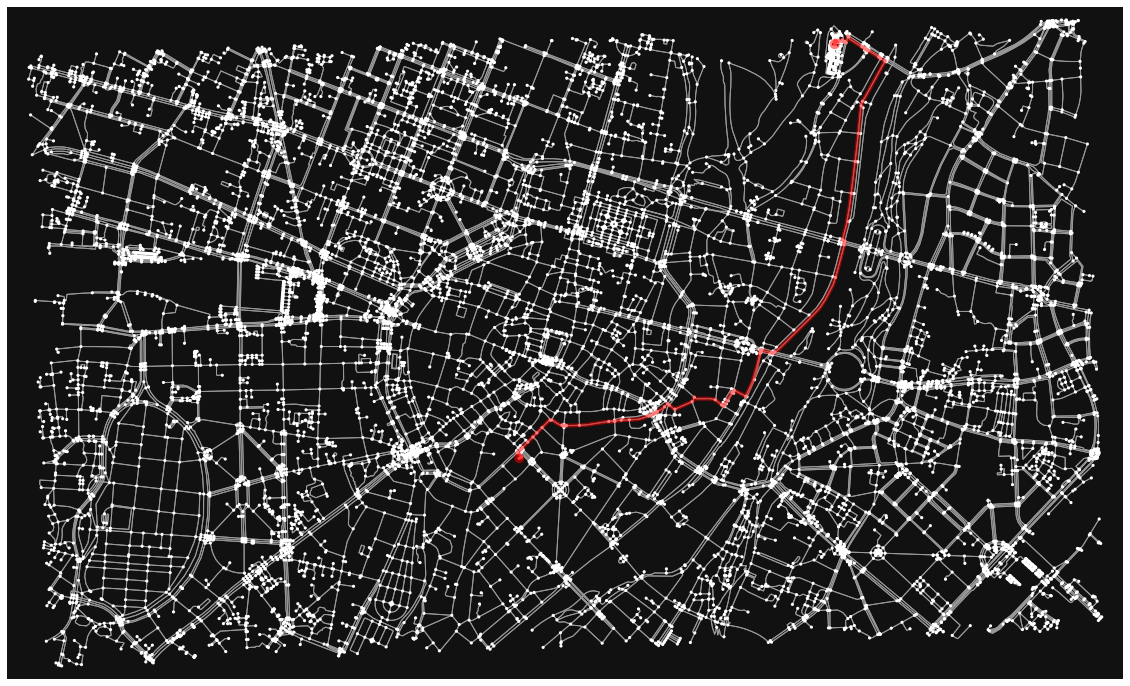

In [397]:
fig, ax = ox.plot_graph_route(graph_projected, track_path, node_size = 10, figsize=(20, 20), dpi=10000)

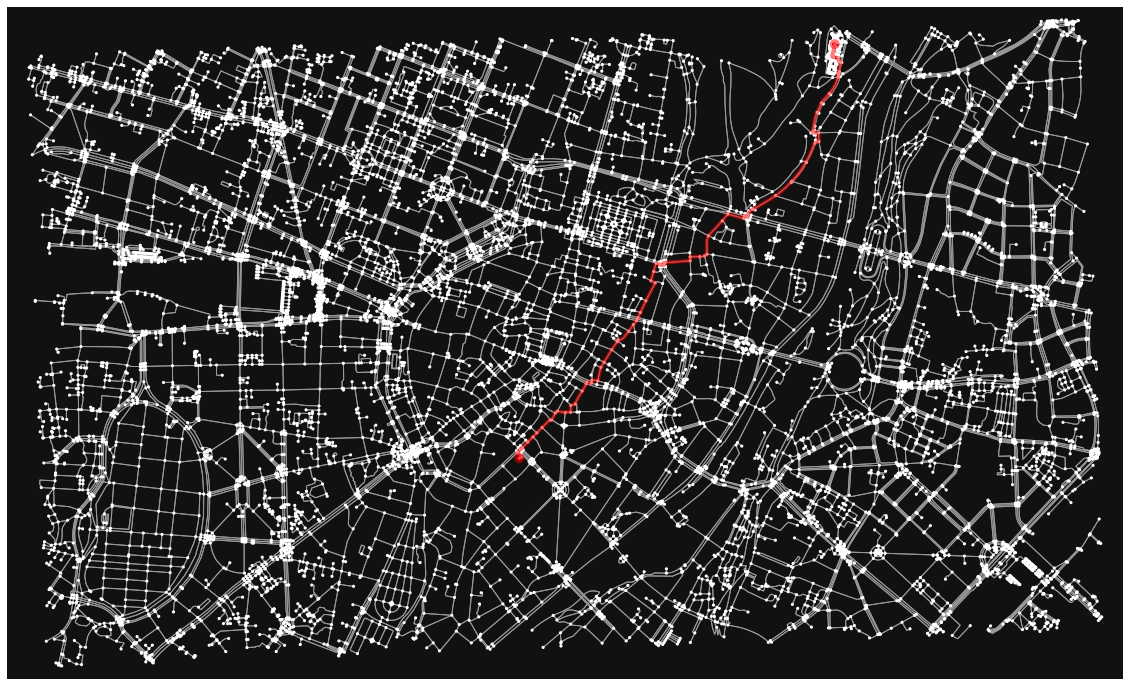

In [391]:
fig, ax = ox.plot_graph_route(graph_projected, fake, node_size = 10, figsize=(20, 20), dpi=10000)

In [381]:
shortest_distance[target]

3481.342

In [382]:
nx.shortest_path_length(graph_projected, source=start, target=target, weight='length', method='dijkstra')

2948.4540000000015

In [385]:
3481.342 - 2948.4540000000015

532.8879999999986

In [398]:
len(fake)

104

In [399]:
len(track_path)

78

In [299]:
for i in range(len(track_path)):
    if track_path[i] != fake[i]:
        print(track_path[i])
        print(fake[i]) 

9442784682
3784409814
1335940715
1335940713
1385803123
1078912467
